# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
import random
import time
import matplotlib.pyplot as plt
import torch
%matplotlib inline

from collections import deque
from workspace_utils import active_session
from ddpg_agent import Agent

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [9]:
def get_actions(states, add_noise):
    action_0 = A0.act(states, add_noise)
    action_1 = A1.act(states, add_noise)
    return np.concatenate((action_0, action_1), axis=0).flatten()

In [10]:
def maddpg(n_episodes=2000, max_t=1000):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode

    """
    scores_window = deque(maxlen = 100)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    c_states = state_size * 2 # combine states

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = np.reshape(env_info.vector_observations, (1,c_states))
        
        A0.reset()
        A1.reset()
        
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, True)
            env_info = env.step(actions)[brain_name]
            next_states = np.reshape(env_info.vector_observations, (1,c_states))
            rewards = env_info.rewards
            done = env_info.local_done
            A0.step(states, actions, rewards[0], next_states, done, 0)
            A1.step(states, actions, rewards[1], next_states, done, 1)
            scores += np.max(rewards)
            states = next_states
            if np.any(done):
                break

        ep_best = np.max(scores)
        scores_window.append(ep_best)
        scores_all.append(ep_best)
        moving_average.append(np.mean(scores_window))
        
        if i_episode % 10 == 0:
            print('\tEpisode {:0>4d}\tMoving Average: {:.3f}'.format(i_episode, moving_average[-1]))

        if moving_average[-1] >= 0.5: 
            print('\n\tEnvironment solved in {:d} episodes! \\n\tMoving Average: {:.3f} (over past {:d} episodes)\n'.format(i_episode-100, moving_average[-1], 100))
            torch.save(A0.actor_local.state_dict(),  'actor0_checkpoint.pth')
            torch.save(A0.critic_local.state_dict(), 'critic0_checkpoint.pth')
            torch.save(A1.actor_local.state_dict(), 'actor1_checkpoint.pth')
            torch.save(A1.critic_local.state_dict(), 'critic1_checkpoint.pth')
            break
                                        
    return scores_all, moving_average

In [11]:
A0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
A1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

	Episode 0010	Moving Average: 0.000
	Episode 0020	Moving Average: 0.015
	Episode 0030	Moving Average: 0.010
	Episode 0040	Moving Average: 0.008
	Episode 0050	Moving Average: 0.008
	Episode 0060	Moving Average: 0.007
	Episode 0070	Moving Average: 0.007
	Episode 0080	Moving Average: 0.009
	Episode 0090	Moving Average: 0.010
	Episode 0100	Moving Average: 0.012
	Episode 0110	Moving Average: 0.012
	Episode 0120	Moving Average: 0.010
	Episode 0130	Moving Average: 0.011
	Episode 0140	Moving Average: 0.013
	Episode 0150	Moving Average: 0.015
	Episode 0160	Moving Average: 0.018
	Episode 0170	Moving Average: 0.017
	Episode 0180	Moving Average: 0.015
	Episode 0190	Moving Average: 0.015
	Episode 0200	Moving Average: 0.013
	Episode 0210	Moving Average: 0.015
	Episode 0220	Moving Average: 0.016
	Episode 0230	Moving Average: 0.015
	Episode 0240	Moving Average: 0.013
	Episode 0250	Moving Average: 0.010
	Episode 0260	Moving Average: 0.010
	Episode 0270	Moving Average: 0.014
	Episode 0280	Moving Average

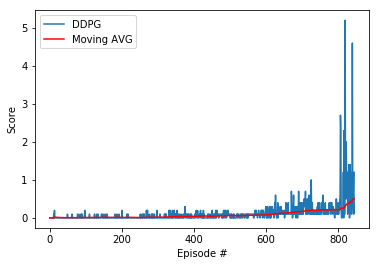

In [12]:
with active_session():
    start = time.time()
    scores, moving_avg = maddpg()
    end = time.time()
    elapsed = (end - start) / 60.0 # in minutes
    print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))
    
    fig = plt.figure()
    ax = fig.add_subplot(111) 
    plt.plot(np.arange(len(scores)), scores, label='DDPG')
    plt.plot(np.arange(len(moving_avg)), moving_avg, c='r', label='Moving AVG')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.savefig('results_v1.png', bbox_inches='tight')
    plt.legend(loc='upper left')
    plt.show()


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 